# 08_NN_MNIST

In [1]:
# Pytorch Library
import torch
import torch.nn.init
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(777)  # reproducibility

In [2]:
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
# Other Python Library
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

### Loading MNIST dataset

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

torch.Size([60000, 28, 28])
torch.Size([60000])


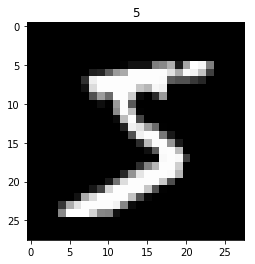

In [5]:
# plot one example
print(mnist_train.train_data.size())                 # (60000, 28, 28)
print(mnist_train.train_labels.size())               # (60000)

idx = 0
plt.imshow(mnist_train.train_data[idx,:,:].numpy(), cmap='gray')
plt.title('%i' % mnist_train.train_labels[idx])

### Data Loader (= 전체 Data를 쪼개서 Batch Size 단위로 불러 오는 역할)

In [7]:
# Hyper-parameters
batch_size = 3000
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

torch.Size([3000, 1, 28, 28])
torch.Size([3000])


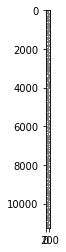

array([4, 1, 6, ..., 4, 0, 5])

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# #예를 들어서.. data_loader로 부터 데이터 뭉치를 하나만 불러 오자
batch_images, batch_labels = next(iter(data_loader))

print(batch_images.size())
print(batch_labels.size())

# show images and print labels
imshow(utils.make_grid(batch_images))
batch_labels.numpy()

# 실제 사용 예시 for loop를 이용해서 image와 label을 읽어 온다.
# for batch_images, batch_labels in data_loader:
#     print(img.size())
#     print(label)

#enumerate를 사용하는 경우 image와 label을 읽는 것 뿐만 아니라 iter도 같이 계산
# for i, (batch_images, batch_labels) in enumerate(data_loader):
#     print(batch_images.size())
#     print(batch_labels)

In [9]:
type(batch_images)
import numpy as np
np.sqrt((batch_images[0,] - batch_images[6,] ).pow(2).sum())

8.3733829179633457

### Define Neural Network Model

In [10]:
class RbfNet(nn.Module):
    def __init__(self, centers, num_class=10):
        super(RbfNet, self).__init__()
        self.centers = centers
        self.num_centers = centers.size(0)
        self.num_class = num_class
    
        self.linear = torch.nn.Linear(self.num_centers, self.num_class, bias=True)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)/10)

    def radial_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)
        C = torch.exp(-self.beta.mul((A-B).pow(2).sum(2,keepdim=False).sqrt() ) )
        return C
    
    def forward(self, batches):
        radial_val = self.radial_fun(batches)
        class_score = self.linear(radial_val)
        return class_score


centers = batch_images
#centers = torch.rand(1000,28*28)
model = RbfNet(Variable(centers.cuda()), num_class=10)
 
model.cuda()

#model.load_state_dict(torch.load('NN.pkl'))  # Load the Trained Model
print(model)

RbfNet (
  (linear): Linear (3000 -> 10)
)


In [11]:
centers.size()

torch.Size([3000, 1, 28, 28])

In [12]:
for parameter in model.parameters():
    print(parameter) 
    
#model.load_state_dict(torch.load('NN.pkl')) 

Parameter containing:
 0.1000  0.1000  0.1000  ...   0.1000  0.1000  0.1000
[torch.cuda.FloatTensor of size 1x3000 (GPU 0)]

Parameter containing:
 6.1721e-03 -1.0911e-02 -1.2007e-02  ...   1.9036e-03  1.7342e-02  9.8540e-03
-1.0860e-02  1.7958e-02 -6.9733e-03  ...  -1.2285e-02  1.1715e-02 -1.3497e-02
 1.0219e-02 -3.8969e-03 -9.9665e-04  ...   1.5645e-03  6.1913e-03  1.3493e-02
                ...                   ⋱                   ...                
-6.1587e-03  1.0285e-02 -1.4230e-02  ...  -8.5106e-03 -1.5129e-02  5.6613e-03
-1.7507e-02 -1.3444e-02 -1.2294e-02  ...  -3.7234e-03  9.8994e-03  1.6329e-02
-1.5913e-02  8.7634e-03 -1.8199e-02  ...  -1.2718e-02  1.2614e-02  3.5766e-03
[torch.cuda.FloatTensor of size 10x3000 (GPU 0)]

Parameter containing:
1.00000e-02 *
  1.0994
 -1.6152
  0.8603
  1.7463
 -0.1176
  0.7831
  0.2706
 -1.6637
  0.8689
  1.4076
[torch.cuda.FloatTensor of size 10 (GPU 0)]



In [13]:
# Hyper-parameters
batch_size = 150
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)


In [14]:
#for _ in range(10):
batch_images, batch_labels = next(iter(data_loader))
model(Variable(batch_images.cuda(), requires_grad=False))

Variable containing:
-0.0360  0.2700 -0.2152  ...   0.1751 -0.0054  0.1743
-0.0227  0.2793 -0.2067  ...   0.1456  0.0239  0.1143
-0.0374  0.2703 -0.2241  ...   0.1452  0.0258  0.1127
          ...             ⋱             ...          
-0.0093  0.2430 -0.1860  ...   0.1443  0.0357  0.0831
-0.0116  0.2663 -0.1878  ...   0.1160  0.0358  0.1098
-0.0253  0.2802 -0.1791  ...   0.1362 -0.0096  0.1107
[torch.cuda.FloatTensor of size 150x10 (GPU 0)]

### Cost 함수 정의

In [15]:
# Softmax 함수가 Cost를 계산할 때 내장되어 있다.
cost_func = torch.nn.CrossEntropyLoss()    

### Model 학습

In [ ]:
# Hyper-parameters
learning_rate = 0.01 
training_epochs = 100

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(mnist_train) // batch_size

    for i, (batch_images, batch_labels) in enumerate(data_loader):
        
        # 이미지를 [batch_size x 784] size 행렬로 변환
        
        X = Variable(batch_images.view(-1, 28 * 28)).cuda()
        Y = Variable(batch_labels).cuda()        # label is not one-hot encoded

        optimizer.zero_grad()             # Zero Gradient Container
        Y_prediction = model(X)           # Forward Propagation
        cost = cost_func(Y_prediction, Y) # compute cost
        cost.backward()                   # compute gradient
        optimizer.step()                  # gradient update

        avg_cost += cost / total_batch

    print("[Epoch: {:>4}] cost = {:>.9}".format(epoch + 1, avg_cost.data[0]))

print('Learning Finished!')
torch.save(model.state_dict(), 'NN.pkl')  # Save the Model

[Epoch:    1] cost = 1.20566511
[Epoch:    2] cost = 0.511912048
[Epoch:    3] cost = 0.442301959
[Epoch:    4] cost = 0.403429091
[Epoch:    5] cost = 0.379295021
[Epoch:    6] cost = 0.358320385
[Epoch:    7] cost = 0.337369591
[Epoch:    8] cost = 0.329559326
[Epoch:    9] cost = 0.324487895
[Epoch:   10] cost = 0.305682033
[Epoch:   11] cost = 0.301581651
[Epoch:   12] cost = 0.285979122
[Epoch:   13] cost = 0.287023187
[Epoch:   14] cost = 0.274200559
[Epoch:   15] cost = 0.266997248
[Epoch:   16] cost = 0.26618138
[Epoch:   17] cost = 0.267345041
[Epoch:   18] cost = 0.254716784
[Epoch:   19] cost = 0.243363231
[Epoch:   20] cost = 0.24887237
[Epoch:   21] cost = 0.241127446
[Epoch:   22] cost = 0.2332986
[Epoch:   23] cost = 0.235295102
[Epoch:   24] cost = 0.224552915
[Epoch:   25] cost = 0.226922065
[Epoch:   26] cost = 0.222697884
[Epoch:   27] cost = 0.222331896
[Epoch:   28] cost = 0.214291126
[Epoch:   29] cost = 0.21221523
[Epoch:   30] cost = 0.212063432
[Epoch:   31] co

In [15]:
model.state_dict()

OrderedDict([('beta', 
               0.2166  0.2861  0.2769  ...   0.2473  0.1988  0.1221
              [torch.cuda.FloatTensor of size 1x5000 (GPU 0)]),
             ('linear.weight', 
              -3.7569e-02 -3.6120e-01  3.8630e-01  ...   3.5091e-01 -2.1983e-01  7.4422e-02
              -2.9959e-01  6.0009e-01 -3.6100e-01  ...  -2.9455e-01 -5.9414e-02  1.2984e-01
               2.1883e-01 -3.4451e-01  6.8182e-02  ...  -1.0338e-01 -1.4275e-01 -1.1496e-01
                              ...                   ⋱                   ...                
              -6.3282e-02  6.9182e-02 -3.1164e-01  ...  -2.9166e-01  4.3582e-02  3.0526e-01
              -2.7239e-02 -5.3782e-02 -1.2934e-01  ...  -1.1819e-01 -1.2814e-01 -1.8660e-01
              -1.2194e-01  6.0939e-02 -2.4678e-01  ...  -4.3307e-01 -2.3870e-01 -5.5325e-02
              [torch.cuda.FloatTensor of size 10x5000 (GPU 0)]),
             ('linear.bias', 
               0.0258
               0.3024
              -0.0371
        

### Test Dataset 이용한 모형 성능 측정

In [139]:
# Test the Model
correct = 0
total = 0
for images, labels in mnist_test:
    images = Variable(images.view(-1, 28*28)).cuda()
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += 1
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


### Random Sample Test

Label:  
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]

Prediction:  
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]



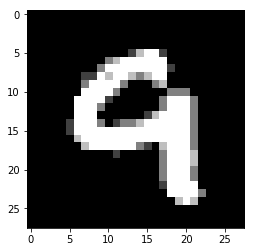

In [126]:
# Get one and predict
r = random.randint(0, len(mnist_test) - 1)
X_single_data = Variable(mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().div(255)).cuda()
Y_single_data = Variable(mnist_test.test_labels[r:r + 1]).cuda()
single_prediction = model(X_single_data)
plt.imshow(X_single_data.cpu().data.view(28,28).numpy() , cmap='gray')

print("Label: ", Y_single_data.data)
print("Prediction: ", torch.max(single_prediction.data, 1)[1])

In [52]:
for i in range(20):
    weight = model[0].weight[i,:].data.view(28,28) 
    weight = (weight - torch.min(weight))/(torch.max(weight)-torch.min(weight))
    plt.imshow( weight.numpy(), cmap='gray')
    plt.show()

TypeError: 'RbfNet' object does not support indexing